In [1]:
%matplotlib inline
!nvidia-smi

Fri Oct 13 01:37:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [3]:
!git clone https://github.com/VikashKumarShaw1994/DNN_invariant_time-rescaling.git DNN_invariant_sithcon

Cloning into 'DNN_invariant_sithcon'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 60 (delta 19), reused 58 (delta 17), pack-reused 0
Receiving objects: 100% (60/60), 6.88 MiB | 6.92 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from DNN_invariant_sithcon.SITHCon.sithcon import SITHCon_Layer
#from SITHCon.SITHCon.sithcon import SITHCon_Layer, _SITHCon_Core, iSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os
from os.path import join
import glob
ttype=torch.cuda.FloatTensor
import numpy as np
import pandas as pd
import pickle
from math import factorial
import random
from itertools import combinations_with_replacement as comb

<class 'torch.cuda.FloatTensor'>


In [5]:
MORSE_CODE_DICT = {'1':'.----', '2':'..---', '3':'...--',
                    '4':'....-', '5':'.....', '6':'-....',
                    '7':'--...', '8':'---..', '9':'----.',
                    '0':'-----', }

# SHORTER
MORSE_CODE_DICT = {'1':'.-', '2':'-...',
                    '3':'-.-.', '4':'-..', '5':'.',
                    '6':'..-.', '7':'--.', '8':'....',
                    '9':'..', '0':'.---',}

In [6]:

print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())



[1 0 1 1 1 0 0 0] 1
[1 1 1 0 1 0 1 0 1 0 0 0] 2
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] 3
[1 1 1 0 1 0 1 0 0 0] 4
[1 0 0 0] 5
[1 0 1 0 1 1 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 0 0] 7
[1 0 1 0 1 0 1 0 0 0] 8
[1 0 1 0 0 0] 9
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 0


<ipython-input-7-27460976e734>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]


(260, 2)


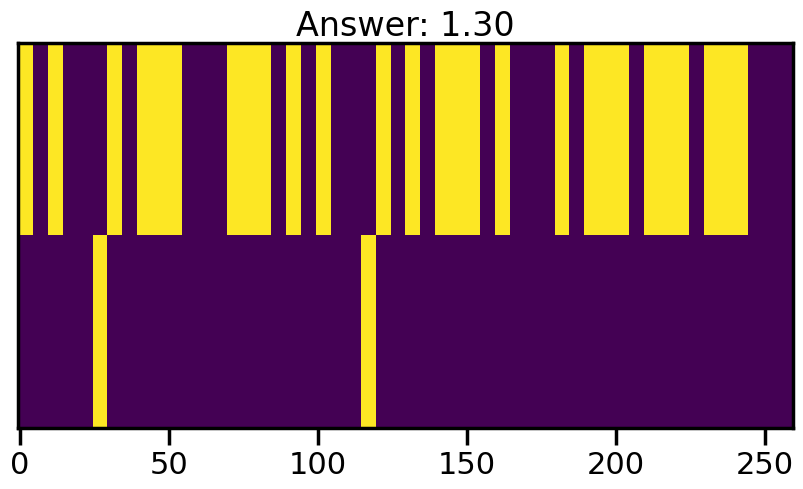

In [7]:
def gen_item(samples=10, scale=5, target_scale=.1):
    # We can tests 1s the same length as the items added together or 1 at the end only.
    keys = morse_code_numpy.keys()
    dim1 = []
    dim2 = []
    half = int(samples / 2)
    added_indexes = [np.random.randint(half),
                     np.random.randint(half, samples)]

    answer = 0
    for s in range(samples):
        # Grab Random Morse Code Letter
        k = random.sample(keys, 1)[0]
        mcl = morse_code_numpy[k]
        Mmcl = mcl.repeat(scale)
        dim1.append(Mmcl[:, np.newaxis])
        if s in added_indexes:

            # dim2.append(np.ones(Mmcl.shape[0])[:, np.newaxis])
            temp = np.zeros(Mmcl.shape[0])[:, np.newaxis]
            temp[-scale:] = 1.0
            #temp[-1] = 1.0 # TRY THIS AT SOME POINT
            dim2.append(temp)
            answer += int(k)
        else:
            dim2.append(np.zeros(Mmcl.shape[0])[:, np.newaxis])
    inp = np.concatenate([np.concatenate(dim1, axis=0),
                          np.concatenate(dim2, axis=0)], axis=1)

    target = np.array([answer])
    return inp, target*target_scale
inp, tar = gen_item(5, 5, .1)
print(inp.shape)
plt.figure(figsize=(10,5))
plt.imshow(inp.T,aspect='auto', interpolation='none')
plt.title("Answer: {:.2f}".format(tar[0]))
plt.yticks([])
plt.savefig(join('figs', 'adding_morse_example'), dpi=100)

In [8]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.tcn(x)
        return self.linear(y1[:, :, -1])

# Three Layers

In [9]:
def gen_model(p):
    model = TCN(2, 1, [25, 25, 25, 25,25,25,25,25], kernel_size=45, dropout=0.0).cuda()
    return model

def test_model(model, X, Y):
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[],
                 'tau_max':[],
                 'ntau':[],
                 'k':[]}

    # BIG NOTE
    # BIG NOTE
    # BIG NOTE
    # Generate the test items once, use in all models at all scales.
    model.eval()
    evald = []
    evaldDict = {'test_perf':[],
                 'rate':[]}
    for nr in range(1,20):
        losses = []
        for iv, tar in items:

            iv = ttype(iv).unsqueeze(0).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
            iv = iv.repeat(1,1,1,1,nr)
            iv = iv.reshape(1,1,2,-1)
            tv = torch.FloatTensor(tar).to(device)
            out = model(iv)

            loss = loss_func(out[:, -1, :],
                                 tv)
            losses.append(loss.detach().cpu().numpy())
        print(nr, np.mean(losses))
        evaldDict['test_perf'].append(np.mean(losses))
        evaldDict['rate'].append(nr)
        evaldDict['tau_max'].append(model.sithcon_layers[0].sithcon.sith.tau_max)
        evaldDict['ntau'].append(model.sithcon_layers[0].sithcon.sith.ntau)
        evaldDict['k'].append(model.sithcon_layers[0].sithcon.sith.k)
    return evaldDict

def save_outcome(outcome, filename):
    dat = pd.DataFrame(outcome)
    dat.to_csv(join('perf',filename))

In [10]:
params = [
           [None],]

In [11]:
model = gen_model(params[0])


tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)

Total Weights: 425026
TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(2, 25, kernel_size=(45,), stride=(1,), padding=(44,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.0, inplace=False)
        (conv2): Conv1d(25, 25, kernel_size=(45,), stride=(1,), padding=(44,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.0, inplace=False)
        (net): Sequential(
          (0): Conv1d(2, 25, kernel_size=(45,), stride=(1,), padding=(44,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv1d(25, 25, kernel_size=(45,), stride=(1,), padding=(44,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.0, inplace=False)
        )
        (downsample): Conv1d(2, 25, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(25, 25, ker

In [27]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

Trainscale = 5
epochs = 500
trials_per_epoch = 1000
batch_size = 32
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx in range(trials_per_epoch):
        optimizer.zero_grad()
        loss = 0
        for i in range(batch_size):
            iv, tar = gen_item(10, Trainscale, .1)
            iv = ttype(iv).unsqueeze(0).transpose(-1,-2)
            tv = ttype(tar)
            out = model(iv)
            loss += loss_func(out,
                              tv)
        loss = loss / batch_size
        loss.backward()
        optimizer.step()

        perfs.append(0)
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]


        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses),
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)
    if (np.sum(perfs)/((len(perfs))) == 1.0) & (np.mean(losses) < .11):
      times_100 += 1
      if times_100 >= 3:
        break
      else:
        times_100 = 0

  0%|     | 0/500 [00:00<?, ?it/s]     

<ipython-input-7-27460976e734>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: ignored

In [12]:
torch.save(model.state_dict(), 'TCN_MorseAdding_5122021.pt')

In [21]:
items = []
for i in range(1000):
    iv, tar = gen_item(10, 1, .1)
    items.append([iv, tar])
np.save('generated_adding_morse',items)

<ipython-input-7-27460976e734>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  k = random.sample(keys, 1)[0]
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
items = np.load('generated_adding_morse.npy', allow_pickle=True)

In [ ]:

# The data below printed is not the actual data, Needs to run on CUDA again, Using previous dill files
# BIG NOTE
# BIG NOTE
# Generate the test items once, use in all models at all scales.
model.eval()
evald = []
device="cuda"
evaldDict = {'test_perf':[],
             'rate':[]}
for nr in range(1,20):
    losses = []
    for iv, tar in items:


        iv = ttype(iv).unsqueeze(0).transpose(-1,-2).unsqueeze(-1)
        iv = iv.repeat(1,1,1,nr)
        iv = iv.reshape(1,2,-1)
        tv = torch.FloatTensor(tar).to(device)
        out = model(iv)
        loss = loss_func(out,
                             tv)
        losses.append(loss.detach().cpu().numpy())
    print(nr, np.mean(losses))
    evaldDict['test_perf'].append(np.mean(losses))
    evaldDict['rate'].append(nr)
    evald.append([nr, np.mean(losses)])
scale_perfs = pd.DataFrame(evaldDict)
directory = "perf"
if not os.path.exists(directory):
    os.makedirs(directory)
scale_perfs.to_pickle(join("perf", "tcn_morseadding_test.dill"))

1 0.78586096
2 0.41909364
3 0.22513774
4 0.17928582
5 0.1623966
6 0.17146687
